# Protein representations

In this notebook you are going to learn more about different methods to encode proteins as vectors. 
First we are going to take a look at basic encoding methods, followed by the training of latent variable models.

The focus of this notebook is to give you some more intuition on how different representations introduce inductive biases into sequences.
We will learn how similar different residues are to each other when using different representations and also how we can use representations to train machine learning models. 

Finally, we will train Autoencoder models using a classical representation of your choice, based on inspiration from the Autoencoders notebook. We will analyze the representation spaces generated by our autoencoders and compare the generative abilities of a regular autoencoder with a variational autoencoder trained on protein sequences.

Once we have analyzed the representation space we can build a classification model using our representations.

In [50]:
import pandas as pd

df = pd.read_csv("../01_Introduction/snake_venoms/Snake_Toxins_with_Function_Classes.csv")
df

,Unnamed: 0,Entry,Entry Name,EC number,Protein names,Sequence,Protein families,Function [CC],Function Class
0,1,A0A0B4U9L8,VMF1_VIPAA,3.4.24.-,Zinc metalloproteinase-disintegrin-like protei...,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s...",FUNCTION: Zinc metalloprotease that has fibrin...,Metalloprotease
1,2,A0A0S4FKT4,VSP1_CRODO,3.4.21.-,Thrombin-like enzyme collinein-1 (SVTLE collin...,VIGGDECNINEHNFLVALYEYWSQSFLCGGTLINGEWVLTAAHCDR...,"Peptidase S1 family, Snake venom subfamily",FUNCTION: Thrombin-like snake venom serine pro...,Serine Protease
2,3,A0A193CHJ5,PA2BC_CROTA,3.1.1.4,Phospholipase A2 crotoxin basic subunit CBc (C...,MRALWIVAVLLVGVEGHLLQFNKMIKFETRKNAIPFYAFYGCYCGW...,"Phospholipase A2 family, Group II subfamily, D...",FUNCTION: Heterodimer CA-CB: Crotoxin is a pot...,Phospholipase
3,4,A0A1Z0YU59,MAMB1_DENAN,NaN,Mambaquaretin-1 (MQ-1) (MQ1) (Upsilon-Da2a),RPSFCNLPVKPGPCNGFFSAFYYSQKTNKCHSFTYGGCKGNANRFS...,Venom Kunitz-type family,FUNCTION: Selectively interacts with vasopress...,Vascular Interaction
4,5,A0A2D0TC04,PDE_NAJAT,3.6.1.-,Venom phosphodiesterase (PDE) (EC 3.6.1.-),LKQSKQPLESCRNRCNETFSEELSYCSCDNKCTERKACCWDYQDIC...,Nucleotide pyrophosphatase/phosphodiesterase f...,FUNCTION: Hydrolyzes ADP with high activity. S...,Hydrolase
...,...,...,...,...,...,...,...,...,...
1732,2395,Q9YGW9,3S12_LATLA,NaN,Short neurotoxin VAN-10,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1733,2396,Q9YGX0,3S14_LATCO,NaN,Short neurotoxin NCA-04,MKTLLLTLVVVTTVCLDLGYTRRCFNQQSSQPKTTKSCPLGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1734,2397,Q9YGX1,3S1ED_LATSE,NaN,Short neurotoxin OKI-Ed,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1735,2398,T1DKS4,TCTP_CROHD,NaN,Translationally-controlled tumor protein homol...,MIIYRDCISQDEMFSDIYKITEVANGLCLEVEGKMVSRKEGEIDDA...,TCTP family,"FUNCTION: Venom protein that causes edema, enh...",Vascular Interaction


## Classical representations

In the lecture we covered classical representations starting with one hot encoding (OHE), Vectors of Hydrophobic, Steric, and Electronic properties (VSHE) encodings, and BLOcks SUbstitution Matrix (BLOSUM) encodings. 


In [51]:
import torch

# Define the VHSE dictionary
vhse_dict = {
    "A": [0.15, -1.11, -1.35, -0.92, 0.02, -0.91, 0.36, -0.48],
    "R": [-1.47, 1.45, 1.24, 1.27, 1.55, 1.47, 1.30, 0.83],
    "N": [-0.99, 0.00, -0.37, 0.69, -0.55, 0.85, 0.73, -0.80],
    "D": [-1.15, 0.67, -0.41, -0.01, -2.68, 1.31, 0.03, 0.56],
    "C": [0.18, -1.67, -0.46, -0.21, 0.00, 1.20, -1.61, -0.19],
    "Q": [-0.96, 0.12, 0.18, 0.16, 0.09, 0.42, -0.20, -0.41],
    "E": [-1.18, 0.40, 0.10, 0.36, -2.16, -0.17, 0.91, 0.02],
    "G": [-0.20, -1.53, -2.63, 2.28, -0.53, -1.18, 2.01, -1.34],
    "H": [-0.43, -0.25, 0.37, 0.19, 0.51, 1.28, 0.93, 0.65],
    "I": [1.27, -0.14, 0.30, -1.80, 0.30, -1.61, -0.16, -0.13],
    "L": [1.36, 0.07, 0.26, -0.80, 0.22, -1.37, 0.08, -0.62],
    "K": [-1.17, 0.70, 0.70, 0.80, 1.64, 0.67, 1.63, 0.13],
    "M": [1.01, -0.53, 0.43, 0.00, 0.23, 0.10, -0.86, -0.68],
    "F": [1.52, 0.61, 0.96, -0.16, 0.25, 0.28, -1.33, -0.20],
    "P": [0.22, -0.17, -0.50, 0.05, -0.01, -1.34, -0.19, 3.56],
    "S": [-0.67, -0.86, -1.07, -0.41, -0.32, 0.27, -0.64, 0.11],
    "T": [-0.34, -0.51, -0.55, -1.06, -0.06, -0.01, -0.79, 0.39],
    "W": [1.50, 2.06, 1.79, 0.75, 0.75, -0.13, -1.01, -0.85],
    "Y": [0.61, 1.60, 1.17, 0.73, 0.53, 0.25, -0.96, -0.52],
    "V": [0.76, -0.92, -0.17, -1.91, 0.22, -1.40, -0.24, -0.03]
}

def vhse_encoder(sequences):
    """
    Encodes sequences using VHSE descriptors.

    Parameters:
        sequences (list or str): List of amino acid sequences or a single sequence.

    Returns:
        torch.Tensor: VHSE encoded tensor of shape
                      (number of sequences, padding or max sequence length, 8)
    """
    # Ensure input is a list
    if isinstance(sequences, str):
        singular = True
        sequences = [sequences]
    else:
        singular = False

    # Determine maximum sequence length and apply padding
    max_sequence_length = max(len(sequence) for sequence in sequences)
    padded_length = max_sequence_length

    n_sequences = len(sequences)
    vhse_size = 8  # VHSE descriptors have 8 components

    # Initialize output tensor with zeros
    tensor = torch.zeros((n_sequences, padded_length, vhse_size))

    # Encode each sequence
    for i, sequence in enumerate(sequences):
        for j, aa in enumerate(sequence):
            if j >= padded_length:
                break
            tensor[i, j] = torch.tensor(vhse_dict.get(aa, [0.5] * vhse_size))  # Default for unknown AAs

    # Squeeze output for single sequence input
    if singular:
        tensor = tensor.squeeze(0)

    return tensor

def one_hot_encode(seq):
    # Dictionary of standard amino acids
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded matrix
    one_hot = torch.zeros((len(seq), len(amino_acids)))

    # Fill the matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_int:
            one_hot[i, aa_to_int[aa]] = 1

    return one_hot

def blosum_62_encoder(sequences):
    """
    Encodes sequences using BLOSUM62 matrix.

    Parameters:
        sequences (list or str): List of amino acid sequences or a single sequence.

    Returns:
        torch.Tensor: BLOSUM62 encoded tensor of shape
                      (number of sequences, padding or max sequence length, 20)
    """
    # Ensure input is a list
    if isinstance(sequences, str):
        singular = True
        sequences = [sequences]
    else:
        singular = False

    # Determine maximum sequence length and apply padding
    max_sequence_length = max(len(sequence) for sequence in sequences)
    padded_length = max_sequence_length

    n_sequences = len(sequences)
    blosum_size = 20  # BLOSUM62 matrix has 20 standard amino acids

    # Initialize output tensor with zeros
    tensor = torch.zeros((n_sequences, padded_length, blosum_size))

    # Encode each sequence
    for i, sequence in enumerate(sequences):
        for j, aa in enumerate(sequence):
            if j >= padded_length:
                break
            # complete the code

    # Squeeze output for single sequence input
    if singular:
        tensor = tensor.squeeze(0)

    return tensor

# Define BLOSUM62 matrix
BLOSUM62 = {
    'A': [ 4, -1, -2, -2,  0, -1, -1,  0, -2, -1, -1, -1, -1, -2, -1,  1,  0,  0, -3, -2],
    'R': [-1,  5,  0, -2, -3,  1,  0, -2,  0, -3, -2,  2, -1, -3, -2, -1, -1, -1, -3, -2],
    'N': [-2,  0,  6,  1, -3,  0,  0,  0,  1, -3, -3,  0, -2, -3, -2,  1,  0, -1, -4, -2],
    'D': [-2, -2,  1,  6, -3,  0,  2, -1, -1, -3, -4, -1, -3, -3, -1,  0, -1, -1, -4, -3],
    'C': [ 0, -3, -3, -3,  9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -2],
    'Q': [-1,  1,  0,  0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -1, -2, -2],
    'E': [-1,  0,  0,  2, -4,  2,  5, -2,  0, -3, -3,  1, -2, -3, -1,  0, -1, -1, -3, -2],
    'G': [ 0, -2,  0, -1, -3, -2, -2,  6, -2, -4, -4, -2, -3, -3, -2,  0, -2, -2, -3, -3],
    'H': [-2,  0,  1, -1, -3,  0,  0, -2,  8, -3, -3, -1, -2, -1, -2, -1, -2, -2,  2, -3],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3,  4,  2, -3,  1,  0, -3, -2, -1, -1, -3,  3],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3,  2,  4, -2,  2,  0, -3, -3, -1, -1, -2,  1],
    'K': [-1,  2,  0, -1, -3,  1,  1, -2, -1, -3, -2,  5, -1, -3, -1,  0, -1, -1, -3, -2],
    'M': [-1, -1, -2, -3, -1,  0, -2, -3, -2,  1,  2, -1,  5,  0, -2, -2, -1, -1, -1,  1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1,  0,  0, -3,  0,  6, -4, -2, -2, -2,  1,  3],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4,  7, -1, -1, -2, -4, -3],
    'S': [ 1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -3,  0, -2, -2, -1,  4,  1,  0, -3, -2],
    'T': [ 0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1,  5,  0, -2, -2],
    'W': [-3, -3, -4, -4, -2, -2, -3, -3,  2, -3, -2, -3, -1,  1, -4, -3, -2, 11,  2, -3],
    'Y': [-2, -2, -2, -3, -2, -2, -2, -3, -3,  3,  1, -2, -1,  3, -3, -2, -2,  2,  7, -1],
    'V': [ 0, -3, -3, -3, -1, -2, -2, -3, -3,  3,  1, -2,  1,  3, -3, -2, -2, -3, -1,  4],
}

# Ensure all vectors have the same length (BLOSUM62 matrix size)
blosum_size = len(next(iter(BLOSUM62.values())))

# Add a "padding" token vector (zero vector)
BLOSUM62['PAD'] = [0] * blosum_size

# Function definition
def blosum_62_encoder(sequences):
    """
    Encodes sequences using BLOSUM62 matrix.

    Parameters:
        sequences (list or str): List of amino acid sequences or a single sequence.

    Returns:
        torch.Tensor: BLOSUM62 encoded tensor of shape
                      (number of sequences, padding or max sequence length, 20)
    """
    # Ensure input is a list
    if isinstance(sequences, str):
        singular = True
        sequences = [sequences]
    else:
        singular = False

    # Determine maximum sequence length and apply padding
    max_sequence_length = max(len(sequence) for sequence in sequences)
    padded_length = max_sequence_length

    n_sequences = len(sequences)

    # Initialize output tensor with zeros
    tensor = torch.zeros((n_sequences, padded_length, blosum_size))

    # Encode each sequence
    for i, sequence in enumerate(sequences):
        for j, aa in enumerate(sequence):
            if j >= padded_length:
                break
            # Map amino acid to BLOSUM62 encoding vector
            tensor[i, j] = torch.tensor(BLOSUM62.get(aa, BLOSUM62['PAD']), dtype=torch.float32)

    # Squeeze output for single sequence input
    if singular:
        tensor = tensor.squeeze(0)

    return tensor

def visualize_representation(representation):
    """
    Visualize different representations as heat maps.
    """
    import matplotlib.pyplot as plt

    # Plot the representation
    plt.figure(figsize=(10, 5))
    plt.imshow(representation.T, cmap="viridis", aspect="auto")
    plt.xlabel("Sequence position")
    plt.ylabel("Feature")
    plt.colorbar(label="Feature value")
    plt.show()


**Task**: Visualize different representations of the dummy sequence "SEQVENCE" using the functions defined above.

In [114]:
seq = "SEQVENCE"

**Solution**

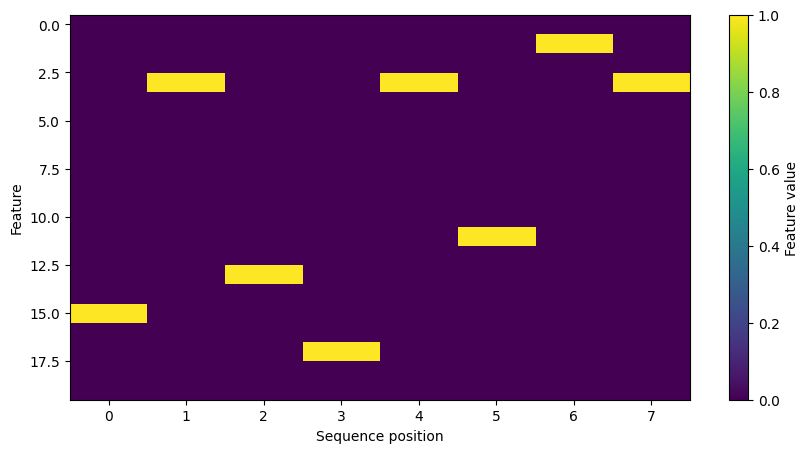

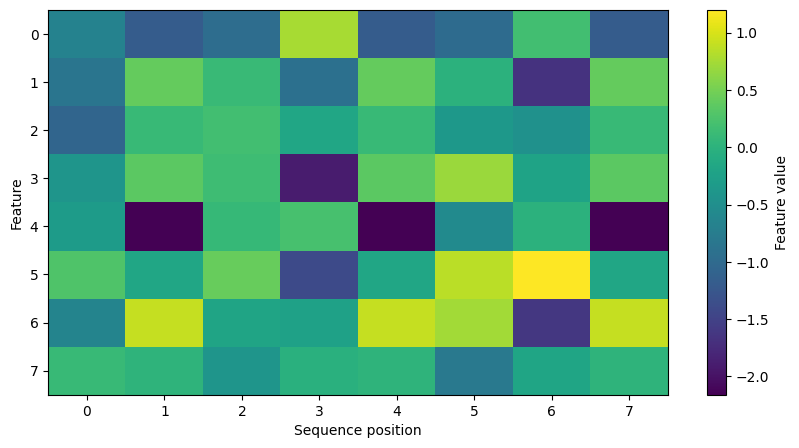

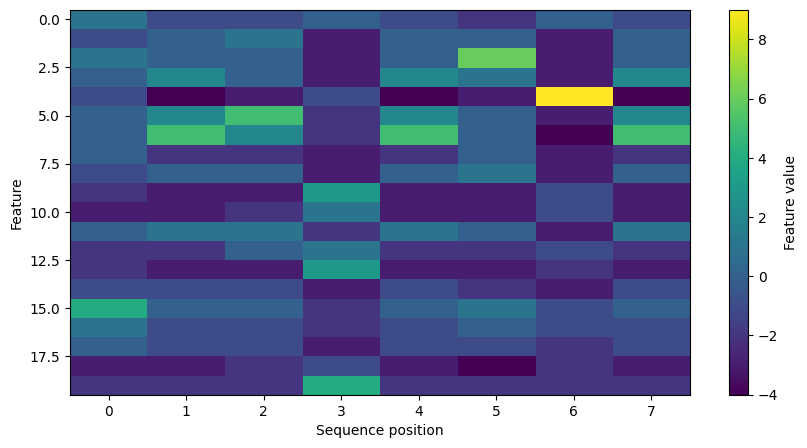

In [115]:
seq_ohe = one_hot_encode(seq)
seq_vhse = vhse_encoder(seq)
seq_blos = blosum_62_encoder(seq)

visualize_representation(seq_ohe)
visualize_representation(seq_vhse)
visualize_representation(seq_blos)

## Computing distances

How similar are different residues to each other using different encoding methods? Which trends can you observe? 

In [53]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def cosine_similarity(rep1, rep2):
    """
    Calculate the cosine similarity between two representations.

    Parameters:
        rep1 (torch.Tensor): First representation tensor.
        rep2 (torch.Tensor): Second representation tensor.

    Returns:
        float: Cosine similarity between the two representations.
    """
    # Flatten representations
    rep1 = rep1.flatten()
    rep2 = rep2.flatten()

    # Calculate the dot product
    dot_product = torch.sum(rep1 * rep2, dim=-1)

    # Calculate the magnitudes
    magnitude1 = torch.norm(rep1, dim=-1)
    magnitude2 = torch.norm(rep2, dim=-1)

    # Calculate the cosine similarity
    similarity = dot_product / (magnitude1 * magnitude2)
    return similarity.item()

def compute_similarity_matrix(encoder, seq):
    """
    Compute a similarity matrix for a given encoder and sequence.

    Parameters:
        encoder (function): Function to encode residues.
        seq (str): Sequence of residues.

    Returns:
        np.ndarray: Similarity matrix.
    """
    num_residues = len(seq)
    similarity_matrix = np.zeros((num_residues, num_residues))
    
    # Encode all residues
    encoded_representations = [encoder(res) for res in seq]
    
    # Compute pairwise cosine similarities
    for i in range(num_residues):
        for j in range(num_residues):
            similarity_matrix[i, j] = cosine_similarity(
                encoded_representations[i], encoded_representations[j]
            )
    return similarity_matrix

def plot_heatmap(similarity_matrix, title, labels):
    """
    Plot a heatmap of the similarity matrix.

    Parameters:
        similarity_matrix (np.ndarray): Similarity matrix to plot.
        title (str): Title of the heatmap.
        labels (list): Labels for the heatmap axes.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Residues")
    plt.ylabel("Residues")
    plt.show()


In [92]:
# Example usage
seq = "ACDEFGHIKLMNPQRSTVWY"
labels = list(seq)

**Solution**

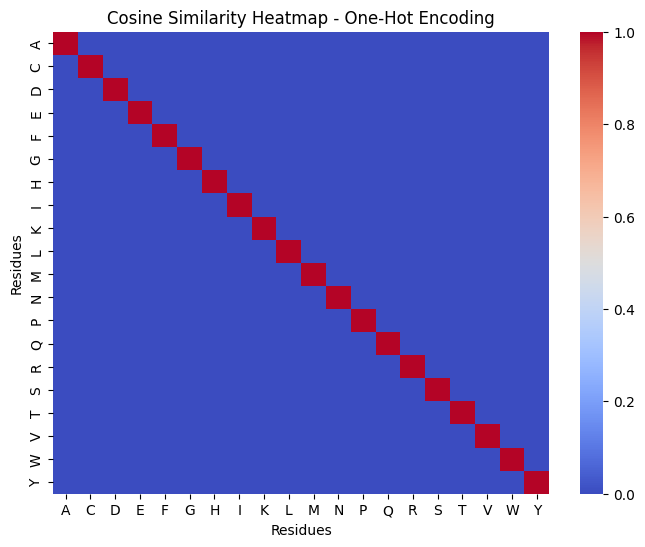

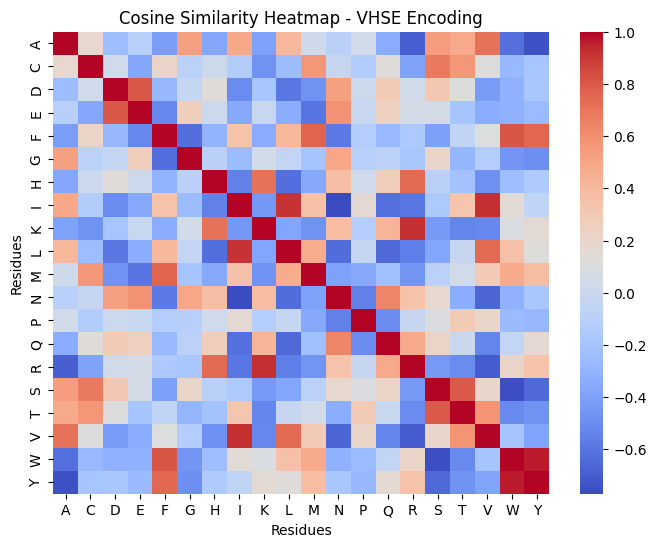

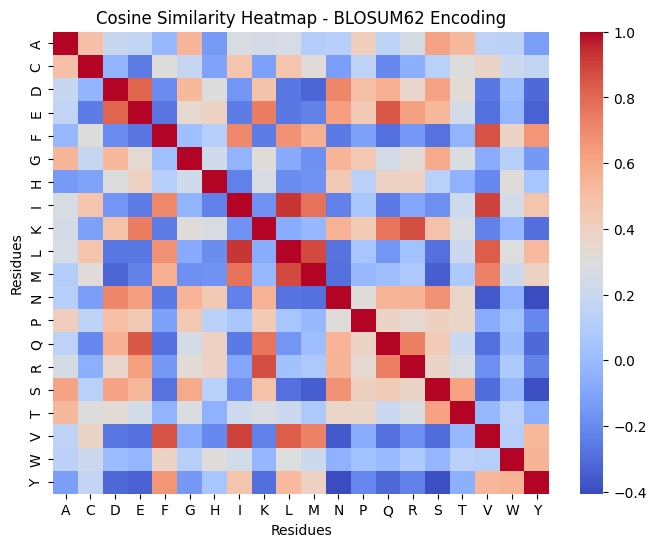

In [54]:
# Compute and plot heatmap for each encoding method
similarity_matrix_ohe = compute_similarity_matrix(one_hot_encode, seq)
plot_heatmap(similarity_matrix_ohe, "Cosine Similarity Heatmap - One-Hot Encoding", labels)

similarity_matrix_vhse = compute_similarity_matrix(vhse_encoder, seq)
plot_heatmap(similarity_matrix_vhse, "Cosine Similarity Heatmap - VHSE Encoding", labels)

similarity_matrix_blosum = compute_similarity_matrix(blosum_62_encoder, seq)
plot_heatmap(similarity_matrix_blosum, "Cosine Similarity Heatmap - BLOSUM62 Encoding", labels)

**Task**: Can you change the order of the sequence below, such that similar residues will cluster together in the heatmap?

Tip: Use the compute_residue_similarty function

In [77]:
seq = "ACDEFGHIKLMNPQRSTVWY"

def compute_residue_similarity(encoder, res1, res2):
    """
    Compute the cosine similarity between two residues, given a specific encoder.
    """
    rep1 = encoder(res1)
    rep2 = encoder(res2)
    return cosine_similarity(rep1, rep2)

**Solution**: We use a Gibbs sampling approach to find an optimal arrangement of residues based on their similarity scores. The similarity between residues is influenced by evolutionary conservation and their physicochemical properties. Residues with similar physicochemical properties are more likely to substitute for each other without disrupting protein function, as these substitutions are often better tolerated evolutionarily. In contrast, substitutions to residues with significantly different properties are less likely to be favored, as they are more likely to disrupt the protein's structure or function. This relationship underpins the rationale for arranging residues by their similarity scores.

In [91]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

def gibbs_sampling_rearrange(encoder, seq, iterations=1000, initial_temp=1.0, cooling_rate=0.99):
    """
    Rearrange a sequence using Gibbs sampling based on cosine similarity.
    """
    # Encode all residues
    encoded_representations = [encoder(res) for res in seq]
    num_residues = len(seq)

    # Compute the similarity matrix
    similarity_matrix = np.zeros((num_residues, num_residues))
    for i in range(num_residues):
        for j in range(num_residues):
            similarity_matrix[i, j] = cosine_similarity(
                encoded_representations[i], encoded_representations[j]
            )
    
    # Initialize sequence and temperature
    current_seq = list(seq)
    current_score = sum(
        similarity_matrix[i, i + 1]
        for i in range(len(current_seq) - 1)
    )
    best_seq = current_seq[:]
    best_score = current_score
    temperature = initial_temp

    for _ in range(iterations):
        # Randomly pick two positions to swap
        i, j = random.sample(range(num_residues), 2)
        new_seq = current_seq[:]
        new_seq[i], new_seq[j] = new_seq[j], new_seq[i]

        # Calculate the new score
        new_score = sum(
            similarity_matrix[k, k + 1]
            for k in range(len(new_seq) - 1)
        )

        # Acceptance probability
        delta_score = new_score - current_score
        acceptance_prob = np.exp(delta_score / temperature) if delta_score < 0 else 1.0

        # Accept or reject the new arrangement
        if random.random() < acceptance_prob:
            current_seq = new_seq
            current_score = new_score

            # Update best sequence
            if current_score > best_score:
                best_seq = current_seq
                best_score = current_score

        # Cool down the temperature
        temperature *= cooling_rate

    return "".join(best_seq)


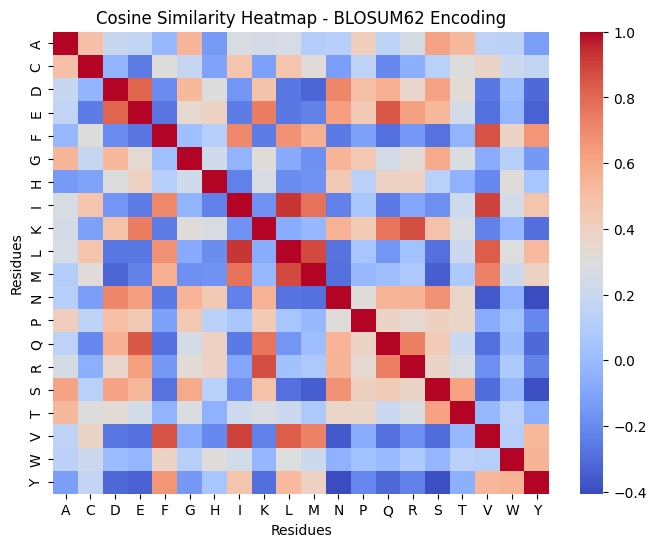

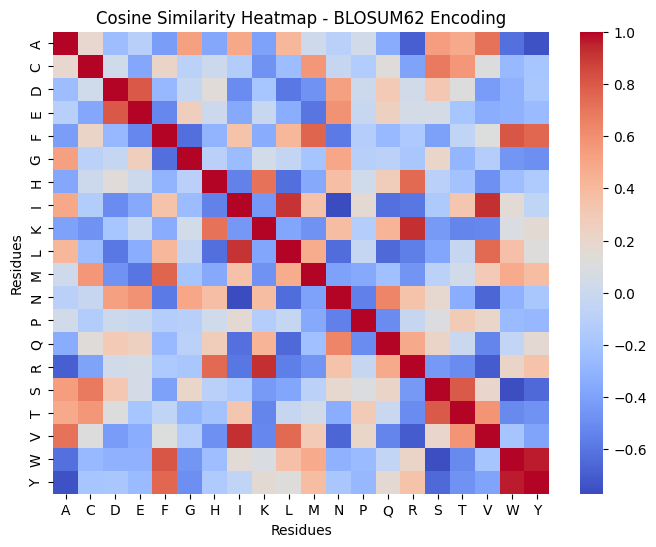

In [90]:
# BLOSUM62 encoding
new_seq_blos = gibbs_sampling_rearrange(blosum_62_encoder, seq)

rearranged_similarity_matrix_blos = compute_similarity_matrix(blosum_62_encoder, new_seq_blos)
plot_heatmap(rearranged_similarity_matrix_blos, "Cosine Similarity Heatmap - BLOSUM62 Encoding", labels)

# VHSE encoding
new_seq_vhse = gibbs_sampling_rearrange(vhse_encoder, seq)

rearranged_similarity_matrix_vhse = compute_similarity_matrix(vhse_encoder, new_seq_vhse)
plot_heatmap(rearranged_similarity_matrix_vhse, "Cosine Similarity Heatmap - BLOSUM62 Encoding", labels)

## Classifying data using classical representations other than OHE

**Task**: Build a classification model using a different classical representation than OHE. Take the snake venom exercise as reference if needed.

In [109]:
# Classify the sequences based on the VHSE encoding
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Manual padding function
def pad_and_flatten(sequences):
    """
    Pad sequences to the same length and flatten them
    """
    max_len = max(seq.shape[0] for seq in sequences)

    # padd sequences
    padded_sequences = []
    for seq in sequences:
        pad_size = max_len - seq.shape[0]
        padded_seq = np.pad(seq, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
        flattened_seq = padded_seq.reshape(-1)
        padded_sequences.append(flattened_seq)

    return np.array(padded_sequences)

# Load X and y from df
X = df['Sequence']
y = df['Function Class']

Accuracy: 0.80


**Solution**: I just used VHSE encodings, you could have also used BLOSUM for example

In [ ]:
# Encode sequences
X_encoded = [vhse_encoder(seq).numpy() for seq in X]

# padd sequences
X_padded = pad_and_flatten(X_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Predict the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

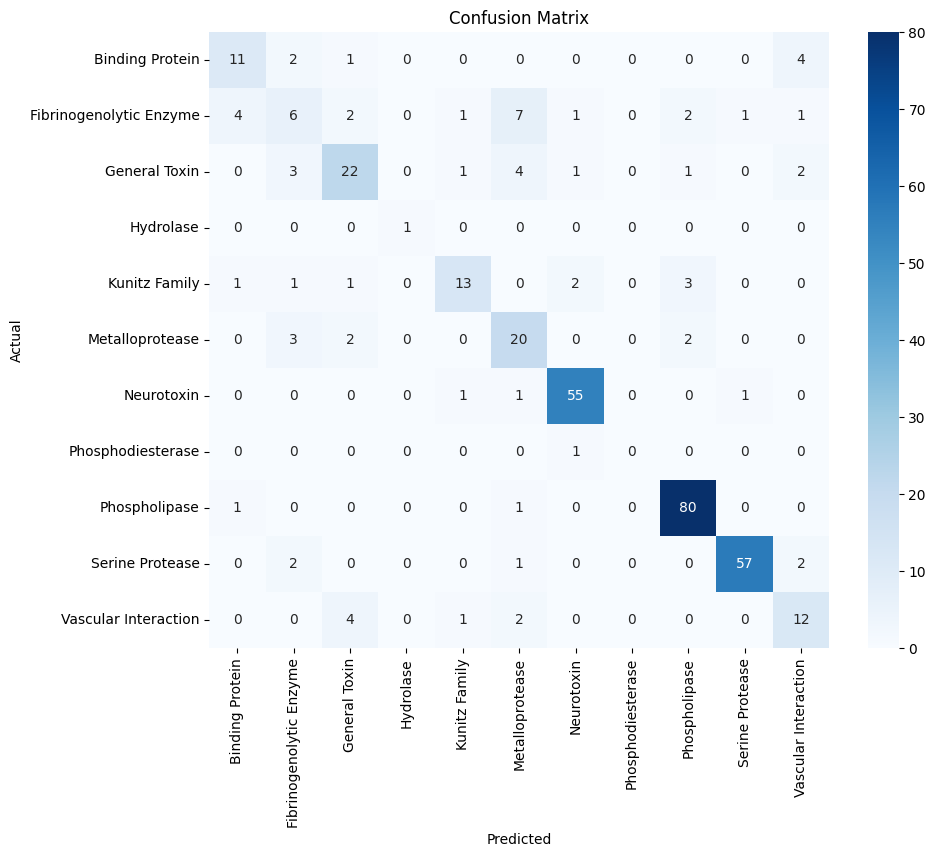

In [111]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Latent variable models

This is the part we have been all waiting for (drummroll), we are now going to build an representation learning model for protein sequences! (yay?)

Use the following guidelines (and especially the Autoencoder notebook) for guidance:

1. pick a classical representation of your choice (OHE, VHSE, BLOSUM62) as your initial representation method.
2. Study the simple autoencoder model architecture and training loop below, that I here train on OHE sequences. Try another representation if you feel adventurous
3. Expand the model architecture to encompass some more interesting convolutional layers.
    a. Play around with the filter sizes and strides and channels.
    b. Add some more filters
4. Turn the autoencoder into a VAE (Tip: create a new class for the VAE, so you can compare the generative capabilities better after training both)
5. Once you have a model that you are satisfied with use more data.
6. Visualize the representations of your trained model.
7. **Optional**: Train a classification model using your representations
8. **Bonus exercise 1 for advanced ML enjoyer** s: Think of ways to sample specific venom classes from your trained VAE? 
    a. Tip: You could try to use generative models to sample from specific regions in latent space.
9. **Bonus exercise 2 for snake enjoyers** : Write a story about your favourite snake :snake:

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProteinAutoencoder(nn.Module):
    def __init__(self, num_filters=32, latent_dim=64, sequence_length=50):
        """
        Args:
            num_filters (int): Number of filters in the convolutional layers.
            latent_dim (int): Size of the latent representation.
            sequence_length (int): Length of the input sequence (N).
        """
        super(ProteinAutoencoder, self).__init__()
        
        # Compute the flattened size after Conv2d
        conv_output_size = sequence_length * num_filters

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(1, 20)),
            nn.ReLU(),
            nn.Flatten(),  # Flattens to (batch_size, sequence_length * num_filters)
            nn.Linear(conv_output_size, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, conv_output_size),
            nn.ReLU(),
            nn.Unflatten(1, (num_filters, sequence_length, 1)),  # Reshapes to (batch_size, num_filters, sequence_length, 1)
            nn.ConvTranspose2d(in_channels=num_filters, out_channels=1, kernel_size=(1, 20))
        )
    
    def forward(self, x):
        """
        Forward pass of the autoencoder.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, N, 20).
        Returns:
            torch.Tensor: Reconstructed input of shape (batch_size, 1, N, 20).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x)  # Bound output to [0, 1]
    
    def encode(self, x):
        """
        Encode input data.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, N, 20).
        Returns:
            torch.Tensor: Encoded representation of shape (batch_size, latent_dim).
        """
        x = self.encoder(x)
        return x
    
    def generate(self, x):
        """
        Generate output data.
        Args:
            x (torch.Tensor): Encoded tensor of shape (batch_size, latent_dim).
        Returns:
            torch.Tensor: Reconstructed input of shape (batch_size, 1, N, 20).
        """
        x = self.decoder(x)
        return torch.sigmoid(x)

In [107]:
# collect sequences from the dataset below length 50
short_sequences = df[df['Sequence'].str.len() < 50]['Sequence'].values

# one-hot encode the sequences
short_sequences_ohe = [one_hot_encode(seq) for seq in short_sequences]

# pad the sequences to the same length
padd_length = 50
short_sequences_ohe_padded = [F.pad(seq, (0, 0, 0, padd_length - seq.size(0))) for seq in short_sequences_ohe]

# create dataset and data loader
batch_size = 32
short_sequences_dataset = torch.stack(short_sequences_ohe_padded)
short_sequences_loader = DataLoader(short_sequences_dataset, batch_size=batch_size, shuffle=True)


In [108]:
# Instantiate the model
model = ProteinAutoencoder(num_filters=32, latent_dim=16)
print(model)

# simple training loop
num_epochs = 10
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch in short_sequences_loader:
        # Forward pass
        outputs = model(batch.unsqueeze(1).float())
        loss = criterion(outputs, batch.unsqueeze(1).float())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

ProteinAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 20), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=1600, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=1600, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 50, 1))
    (3): ConvTranspose2d(32, 1, kernel_size=(1, 20), stride=(1, 1))
  )
)
Epoch 1/10, Loss: 0.2538
Epoch 2/10, Loss: 0.1966
Epoch 3/10, Loss: 0.1206
Epoch 4/10, Loss: 0.0656
Epoch 5/10, Loss: 0.0411
Epoch 6/10, Loss: 0.0353
Epoch 7/10, Loss: 0.0310
Epoch 8/10, Loss: 0.0262
Epoch 9/10, Loss: 0.0257
Epoch 10/10, Loss: 0.0278
